In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import datasets, transforms

from utils.helper import fn_plot_torch_hist

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 41 # number of epochs

BATCH_SIZE = 32

ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.8
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [5]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Read Flowers data set

In [7]:
###---------------
### Transformation
###---------------

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [8]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [9]:
dataset_size = len(dataset)

test_size = int(TEST_SIZE*dataset_size) # 22*32

train_size = dataset_size - test_size
print (dataset_size, train_size, test_size)

3670 2936 734


In [10]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:-test_size])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[-test_size:])

In [11]:
class_names = train_dataset.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
numClasses = len(class_names)
numClasses

5

In [13]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

## Data Loader

In [14]:
#torch.utils.data.DataLoader?

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

91 22


In [16]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0))

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means
    
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')

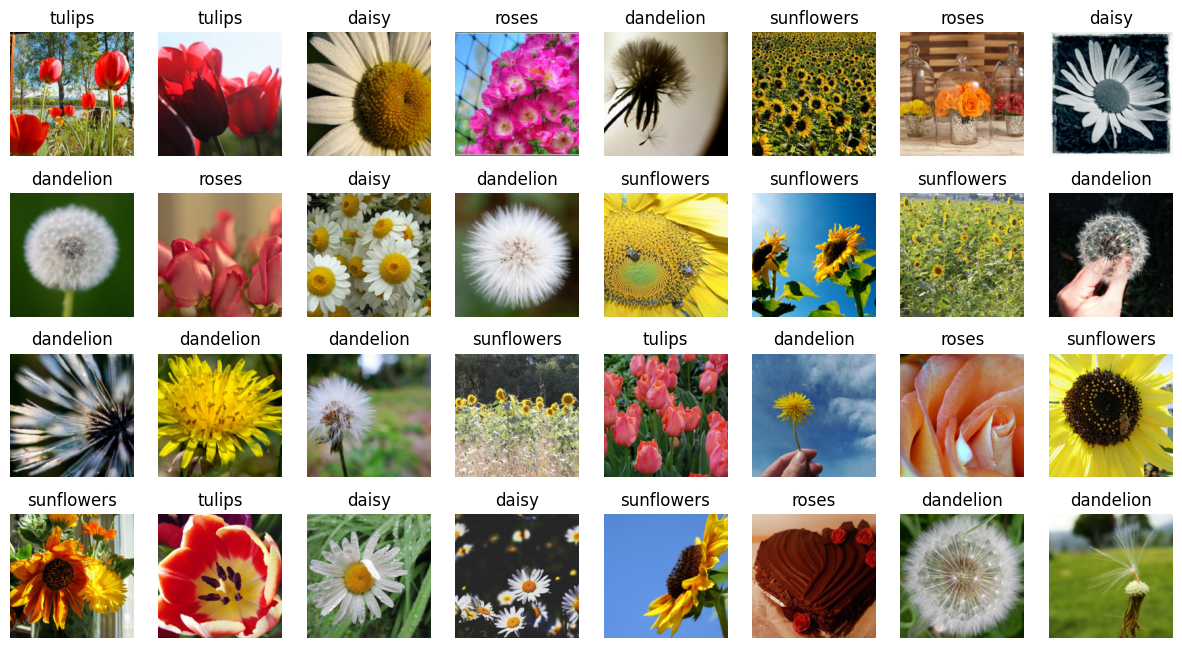

In [17]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].numpy()])

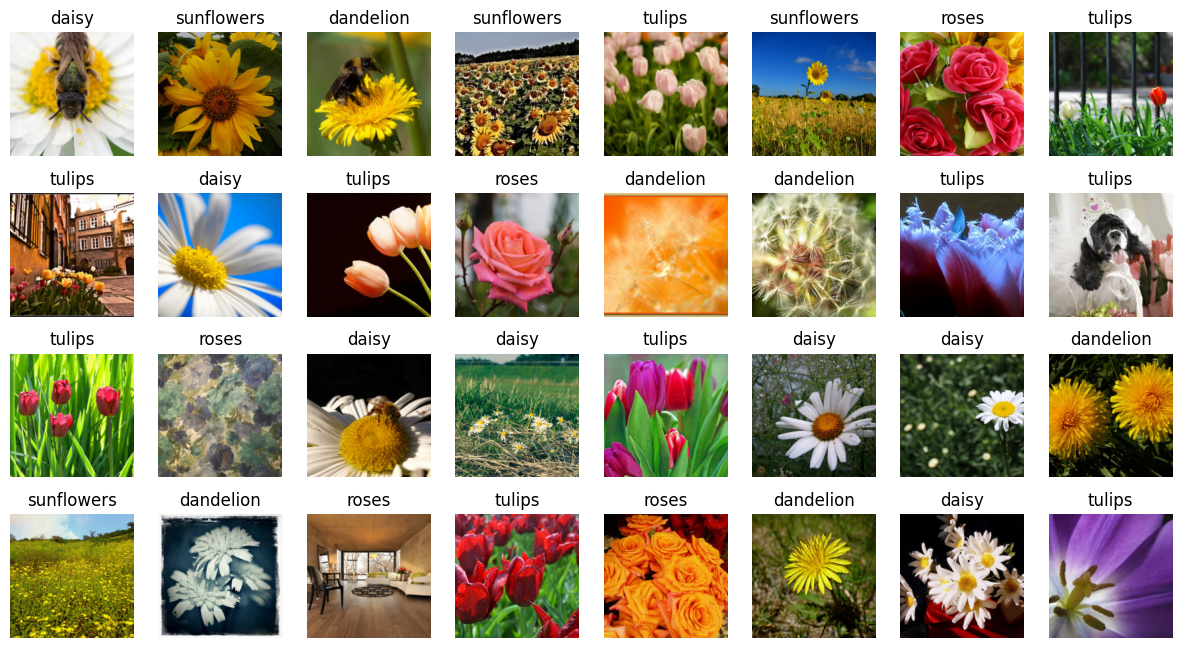

In [18]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].numpy()])